In [1]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
mpl.style.use('../../paper.mcstyle')
import matplotlib.cm as cm

    
from scipy.stats import gaussian_kde


import pandas as pd
from sklearn.neighbors import NearestNeighbors

from multiprocessing import cpu_count
from multiprocessing import Pool

import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn

import ili
from ili.dataloaders import NumpyLoader, TorchLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior
from CNN import ConvNet


In [2]:
def pdf(m, alpha):
        norm_const = (m_max**(1-alpha) - m_min**(1-alpha))/(1-alpha) 
        return (1/norm_const)* m**(-alpha)
def cdf(m, alpha):
    norm_const = (m_max**(1-alpha) - m_min**(1-alpha))/(1-alpha) 
    return (1/norm_const)* (1/(1-alpha)) * (m**(1-alpha) - m_min**(1-alpha))

def inverse_cdf(y, alpha):
    norm_const = (m_max**(1-alpha) - m_min**(1-alpha))/(1-alpha) 
    return (y*norm_const*(1-alpha) + m_min**(1-alpha))**(1/(1-alpha))

def gen_non_repeated_halo(samples, masses, times, M_tot, nbrs, d):
    """
    Function to return the Galaxy name, mass and infall time obtain by sampling the mass function and then looking for Neighbors in the mass space.
    If the sample is too far away from the mass function, 5 new samples are drawn and we randomly select one of them, if they are enough close and not already in the sample list.
    If the total mass is not reached we break the loop and return the list of samples, masses and times.
    
    Parameters:
    samples: list of galaxy names
    masses: list of galaxy masses
    times: list of galaxy infall times
    M_tot: total mass budject for the galaxy halo
    nbrs: NearestNeighbors object to look for the neighbors in the mass space
    d: percentale of the mass that the sample can be far away from the mass function
    
    Returns:
    samples: updated list of galaxy names
    masses: updated  list of galaxy masses
    times: updated list of galaxy infall times
    
    """
    iteration = 0
    while iteration < 100: #number of max halos to be sampled
        if M_tot < mass_nn.min():
            break
        max_u = cdf(M_tot, alpha)
        analictical_sample = inverse_cdf(np.random.uniform(0, max_u), alpha, ).reshape(-1, 1)
        distances, indices = nbrs.kneighbors(analictical_sample)
        sample = galaxy_name[indices[0]][0][0]
        mass_sample = mass_nn[indices[0]][0][0]
        time_sample = infall_time[indices[0]][0][0]
        if (abs(mass_sample - analictical_sample) > d*analictical_sample) | (sample in samples):
            nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(mass_nn)
            analytic_10_samples = inverse_cdf(np.random.uniform(0, 1, size=5), alpha, ).reshape(-1, 1)
            distances, indices = nbrs.kneighbors(analytic_10_samples)
            galaxy_10 = galaxy_name[indices]
            mass_10 = mass_nn[indices]
            time_10 = infall_time[indices]
            mask =  (distances < d*analytic_10_samples).reshape(galaxy_10.shape)&(~np.isin(galaxy_10, samples))
            if (mask.sum() == 0):
                if (((6*1e9-M_tot)/(6*1e9))<0.95):
                    # print(f'No halos satified the requirement, total mass is: {((6*1e9-M_tot)/(6*1e9))*100:.2f} %') #this is for studying rejection of not completed galaxy
                    samples = None
                    masses = None
                    times = None
                    return samples, masses, times
                else:
                    break #when the 95% of the total mass is reach we keep only those samples and we do not add more
            else:
                sampled_index = np.random.choice(range(len(mass_10[mask].flatten())))
                mass_sample =  mass_10[mask].flatten()[sampled_index]
                sample = galaxy_10[mask].flatten()[sampled_index]
                time_sample  = time_10[mask].flatten()[sampled_index]
        samples.append(sample)
        masses.append(mass_sample)
        times.append(time_sample)

        M_tot = M_tot - mass_sample
        iteration += 1 
    return samples, masses, times


def gen_real_halo(j, galaxy_name, mass_nn, infall_time, galaxies_test=None, d=0.1, ):
    """
    Generate a real halo by sampling the mass function and then looking for Neighbors in the mass space.
    Returns the histogram of the galaxy, the mass and the infall time of the galaxy.
    If the test set is provided, it checks if the galaxy is already present in the test set, if so it generates a new one untill it is not present anymore.
    
    Parameters:
    j: index of the galaxy to be generated
    galaxy_name: list of galaxy names
    mass_nn: list of galaxy masses
    infall_time: list of galaxy infall times
    galaxies_test: list of set of galaxy names in the test set
    d: percentale of the mass that the sample can be far away from the mass function
    
    Returns:
    hist_to_return: histogram of the galaxy, repeated as many time as the number of subhalos
    masses: masses of the subhalos
    infall_time: galaxy name of the subhalos
    """
    
    
    np.random.seed(j)
    N=2
    nbrs = NearestNeighbors(n_neighbors=N, algorithm='ball_tree').fit(mass_nn)
    # M_tot = 6 * 1e9
    M_tot = 1.4 * 1e9
    samples = []
    masses =  []
    times = []
    #generate a milky way galaxy like halo
    samples, masses, times = gen_non_repeated_halo(samples, masses, times, M_tot, nbrs, d)
    
    #check if the milky way like halo is in the test set, otherwise genereate a new one untill is not present anymore in the test set
    if (galaxies_test is not None)&(samples is not None):
        while any(set(samples) == galaxy_in_testset for galaxy_in_testset in galaxies_test):
            samples = []
            masses =  []
            times = []
            samples, masses, times = gen_non_repeated_halo(samples, masses, times, M_tot, nbrs, d)
    if samples is None:
        return np.array([]), np.array([]), np.array([])

    #get the galaxy name to load the histogram from memory 
    samples =  np.array(samples)
    arr = np.array([np.load('/export/data/vgiusepp/data/full_dataframe/histogram_data/'+f'{s}'+'.npz' )['observables']  for s in samples ])
    #some all the histogram to obtain the 0th channel 
    hist_0 = np.sum( arr, axis=0)
    hist_to_return = [np.stack([hist_0, np.ones_like(hist_0)*i]) for i in range(samples.shape[0])]  #nasty trick to allow to save both the N_th number and the histogram in the same array
    
    masses = np.array(masses)
    infall_time = np.array(infall_time)
    indices = np.argsort(masses)[::-1] #sort the masses in descending order
    
    #reorder masses and infall time
    masses = masses[indices]
    infall_time = infall_time[indices]
    samples = samples[indices]
    
    return hist_to_return, np.column_stack([masses, infall_time]), np.array([samples for i in range(samples.shape[0])]) # I want for each of the hist to have all the names of the galaxies that contributed to it, I cannot flatten it 


if __name__ == '__main__':

    data = pd.read_parquet('/export/data/vgiusepp/data/full_dataframe/dataframe/dataframe.parquet')
    data['star_log10mass'] = 10**data['star_log10mass']
    data_mass = data['star_log10mass'].drop_duplicates()
    data_mass = data_mass[data_mass<1.4*1e9]
    
    m_min, m_max = data_mass.min(), data_mass.max()
    alpha = 1.25
   
    mass_name = data[['star_log10mass', 'Galaxy_name', 'infall_time']].drop_duplicates()
    mass_name = mass_name[mass_name['star_log10mass']<6*1e9]
    min_feh, max_feh = data['feh'].min(), data['feh'].max() 
    min_ofe, max_ofe = data['ofe'].min(), data['ofe'].max()
    mass_nn = mass_name['star_log10mass'].values.reshape(-1, 1)
    infall_time = mass_name['infall_time'].values.reshape(-1, 1)
    galaxy_name = mass_name['Galaxy_name'].values.reshape(-1, 1)
    
    test_set_sample = 100
    train_set_sample = 1_000

    mass_nn = mass_name['star_log10mass'].values.reshape(-1, 1)
    infall_time = mass_name['infall_time'].values.reshape(-1, 1)
    galaxy_name = mass_name['Galaxy_name'].values.reshape(-1, 1)
    with Pool(processes=cpu_count()) as p:
        result = p.starmap(gen_real_halo, [[j, galaxy_name, mass_nn, infall_time] for j in range(test_set_sample)]   )

    hist_list_test, params_list_test, galaxy_list_test = zip(*result)

    #create the filter to take only the unique galaxies 
    single_galaxy_test = [arr[0] for arr in galaxy_list_test if arr.size > 0]
    unique_indices_test = list({tuple(arr): i for i, arr in enumerate(map(tuple, single_galaxy_test))}.values())
    print('unique galaxy in the test set that are not empty:', len(unique_indices_test))

    flattened_hist_list_test = [item for i, sublist in enumerate(hist_list_test) if i in unique_indices_test for item in sublist]
    flattened_param_list_test = [item for i, sublist in enumerate(params_list_test) if i in unique_indices_test for item in sublist]
    flattened_hist_list_test =  np.array(flattened_hist_list_test)
    flattened_param_list_test =  np.array(flattened_param_list_test)
    galaxies_test = [set(arr[0]) for arr in galaxy_list_test if arr.size > 0] #list that contains set of names of the galaxy in the test set to compare it with the training set 


    with Pool(processes=cpu_count()) as p:
        result = p.starmap(gen_real_halo, [[j+test_set_sample, galaxy_name, mass_nn, infall_time, galaxies_test] for j in range(train_set_sample)]   )

    hist_list, params_list, galaxy_list = zip(*result)

    #create the filter to take only the unique galaxies 
    single_galaxy = [arr[0] for arr in galaxy_list if arr.size > 0]
    unique_indices = list({tuple(arr): i for i, arr in enumerate(map(tuple, single_galaxy))}.values())
    flattened_hist_list = [item for i, sublist in enumerate(hist_list) if i in unique_indices for item in sublist]
    flattened_param_list = [item for i, sublist in enumerate(params_list) if i in unique_indices for item in sublist]
    flattened_hist_list =  np.array(flattened_hist_list)
    flattened_param_list =  np.array(flattened_param_list)
    print('unique galaxy in the training set that are not empty:', len(unique_indices))
    
    mask = [flattened_hist_list[:, 1, 0, 0] < np.random.uniform(low=0, high=100, size=len(flattened_hist_list[:, 1, 0, 0])) ][0] #applying a mask to not overfit on high N
    # mask = [flattened_hist_list[:, 1, 0, 0] < 20 ][0] #applying a mask to not overfit on high N
    training_x = flattened_hist_list[mask]
    training_theta = flattened_param_list[mask]


    test_x = torch.log1p(torch.from_numpy(flattened_hist_list_test)).float()
    test_theta = torch.log10(torch.from_numpy(flattened_param_list_test)).float()

    x = torch.log1p(torch.from_numpy(training_x)).float()
    theta = torch.log10(torch.from_numpy(training_theta)).float()
    
    
    gpu_index = 6  # replace with your desired GPU index
    torch.cuda.set_device(gpu_index)
    device = f"cuda:{gpu_index}"
    conditions  = mass_name[['star_log10mass', 'infall_time']]
    minimum_theta = [np.log10(conditions[col].values.min()) for col in conditions.columns]   
    maximum_theta = [np.log10(conditions[col].values.max()) for col in conditions.columns]    

    
    def write_to_yaml(minimum_theta, maximum_theta, device):
        # Load the existing data
        with open('./training.yaml', 'r') as file:
            data = yaml.safe_load(file)
            
        # Update the value
        # data['prior']['args']['low'] = minimum_theta[0]
        # data['prior']['args']['high'] = maximum_theta[0]
        data['device'] = device

        # Write the data back to the file
        with open('./training.yaml', 'w') as file:
            yaml.safe_dump(data, file)
            
    # write_to_yaml(minimum_theta, maximum_theta, device)
    print('write the right prior in the training.yaml file')
    
    


unique galaxy in the test set that are not empty: 97
unique galaxy in the training set that are not empty: 982
write the right prior in the training.yaml file


In [3]:
gpu_index = 0  # replace with your desired GPU index
torch.cuda.set_device(gpu_index)
device = f"cuda:{gpu_index}"

In [4]:
class CustomDataset(Dataset):
    def __init__(self, observation, parameters, ):
        self.observation = observation
        self.parameters = parameters
        
        self.tensors = [self.observation, self.parameters]

    def __len__(self):
        return len(self.observation)

    def __getitem__(self, idx):
        observation = self.observation[idx].to('cuda') #this should put just the batch on the gpu
        parameters = self.parameters[idx].to('cuda')
        
        # observation = self.observation[idx] #this should put just the batch on the gpu
        # parameters = self.parameters[idx]

        return observation, parameters
    
    
# test_dataset = CustomDataset(x_0, theta_0)

# Split the original training dataset into a new training dataset and a validation dataset
# Here, we use 80% of the images for training and 20% for validation
# Assuming data and targets are your full dataset and labels
data_size = len(x)
print(data_size)    
indices = np.random.permutation(data_size)

# Decide on the split size, for example 80% for training and 20% for validation
split_idx = int(data_size * 0.8)

# Split the indices
train_indices, val_indices = indices[:split_idx], indices[split_idx:]

# Create the data splits
train_data, train_targets = x[train_indices].float(), theta[train_indices].float()
val_data, val_targets = x[val_indices].float(), theta[val_indices].float(),

# Now you can create your DataLoaders
train_loader = torch.utils.data.DataLoader(CustomDataset(train_data.to('cuda'), train_targets.to('cuda'),), shuffle=True, batch_size=2024)
val_loader = torch.utils.data.DataLoader(CustomDataset(val_data.to('cuda'), val_targets.to('cuda'),), shuffle=False, batch_size=2024)
# test_loader = DataLoader(test_dataset,  shuffle=False)

loader = TorchLoader(train_loader=train_loader, val_loader=val_loader)
# runner = InferenceRunner.from_config(f"./training.yaml")

# define training arguments
train_args = {
    'training_batch_size': 1024,
    'learning_rate': 5e-5,
    'stop_after_epochs': 20
}

# instantiate a CNN embedding network
embedding_net =  ConvNet(output_dim=32).to('cuda')

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_lampe(model='nsf', hidden_features=100, num_transforms=20,
                        embedding_net=embedding_net, x_normalize=False, device=device),
    ili.utils.load_nde_lampe(model='nsf', hidden_features=100, num_transforms=20,
                        embedding_net=embedding_net, x_normalize=False, device=device),
    ili.utils.load_nde_lampe(model='nsf', hidden_features=100, num_transforms=20,
                        embedding_net=embedding_net, x_normalize=False, device=device),
    ili.utils.load_nde_lampe(model='nsf', hidden_features=100, num_transforms=20,
                        embedding_net=embedding_net, x_normalize=False, device=device),
]

prior = ili.utils.Uniform(low=minimum_theta, high=maximum_theta, device=device)

    # initialize the trainer
runner = InferenceRunner.load(
    backend='lampe',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    train_args=train_args,
    proposal=None,
    out_dir='./',
)

posterior_ensemble, summaries = runner(loader=loader,)



43842


INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 4.
250 epochs [11:46,  2.83s/ epochs, loss=-0.693, loss_val=-0.597] 
INFO:root:Training model 2 / 4.
244 epochs [11:42,  2.88s/ epochs, loss=-0.722, loss_val=-0.677]
INFO:root:Training model 3 / 4.
232 epochs [10:41,  2.77s/ epochs, loss=-0.68, loss_val=-0.601]  
INFO:root:Training model 4 / 4.
348 epochs [15:58,  2.75s/ epochs, loss=-0.735, loss_val=-0.724]  
INFO:root:It took 3013.140905380249 seconds to train models.
INFO:root:Saving model to .


In [5]:
#paper column width is 397.48499pt
pt = 1/72.27
column_width = 397.48499*pt
aspect_ratio = 1.61803398875
my_width = column_width
my_height = my_width/aspect_ratio


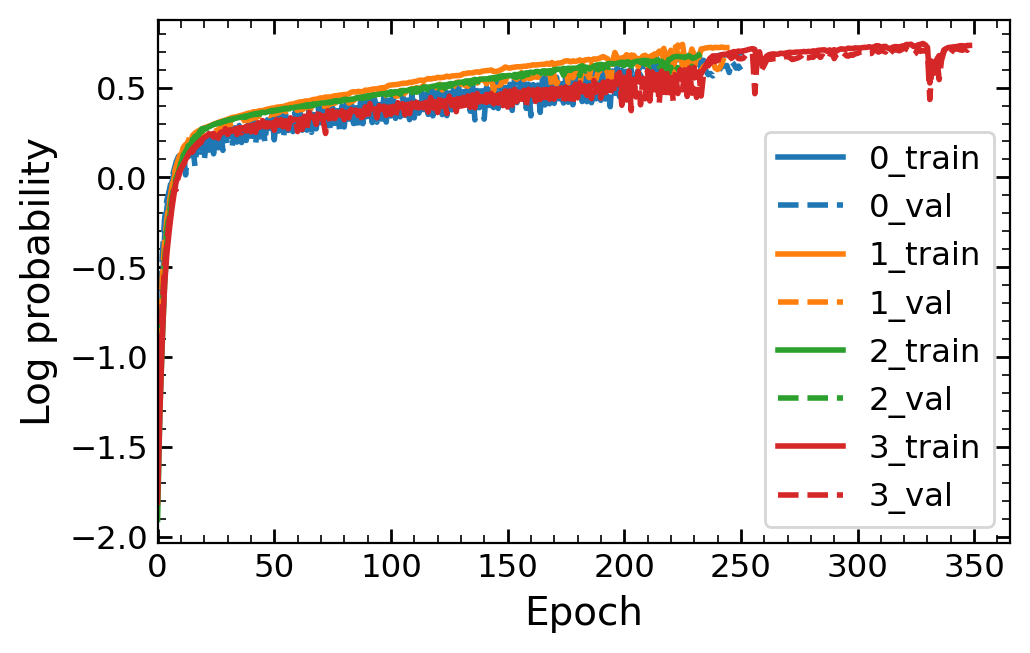

In [6]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(my_width,my_height))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()
fig.savefig('./train_val_loss.png')

In [8]:
mpl.style.use('../../paper.mcstyle')

/tmp/ipykernel_3111440/2363721285.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')  # 'viridis' is the colormap name


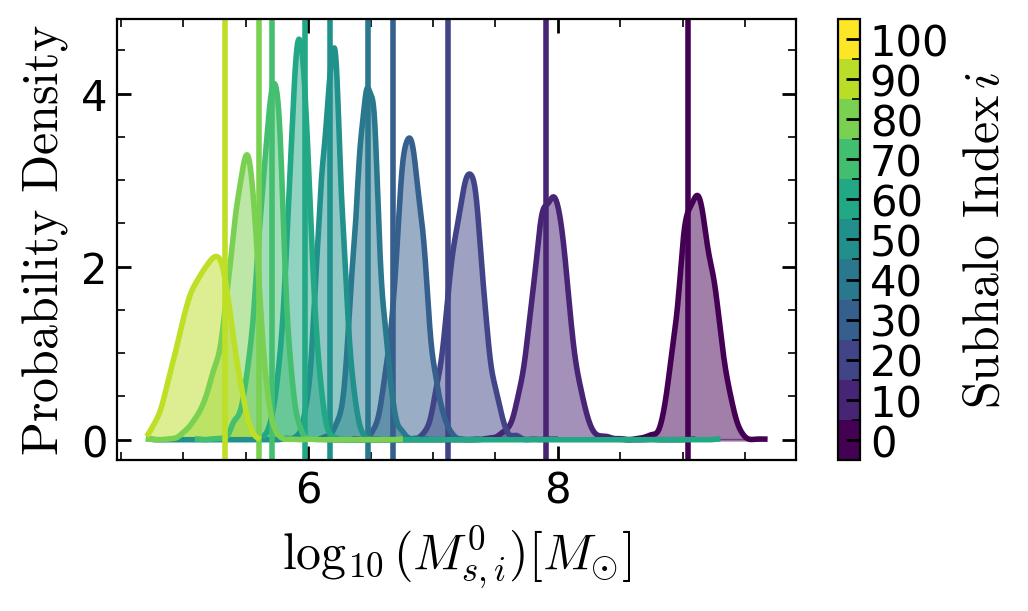

In [32]:

# Create a colormap
cmap = cm.get_cmap('viridis')  # 'viridis' is the colormap name

# Create a list of colors
colors = [cmap(i) for i in np.linspace(0, 1, 11)]  # Replace 10 with the number of colors you want

fig, ax = plt.subplots(1, 1, figsize=(my_width,my_height))
for (c,i) in enumerate(range(100)[::10]):
    samples = posterior_ensemble.sample((2_000,), x=test_x[i].unsqueeze(0).to(device), show_progress_bars=False) 
    samples =  samples[:, 0].cpu().numpy()
    density = gaussian_kde(samples)
    density_val = density(np.linspace(min(samples), max(samples), 1000))
    ax.plot(np.linspace(min(samples), max(samples), 1000), density_val, color=colors[c])    
    ax.fill_between(np.linspace(min(samples), max(samples), 1000), density_val, alpha=0.5, color=colors[c])
    ax.axvline(x=test_theta[i][0].cpu().numpy(), color=colors[c])

ax.set_xlabel(r'$\log_{10}(M_{s,i}^0) [M_{\odot}]$')
ax.set_ylabel(r'$\text{Probability Density}$')


norm = mcolors.BoundaryNorm(boundaries=np.arange(-0.5, 11, 1), ncolors=cmap.N)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Only needed for matplotlib < 3.1

# Add the colorbar to the figure
cbar = fig.colorbar(sm, ax=ax, ticks=np.arange(11))
cbar.ax.set_yticklabels([f'{i*10}' for i in range(11)])  # Set the labels for the colorbar
cbar.set_label(r'$\text{Subhalo Index} \, i$')
fig.tight_layout()
# ax.set_xscale('log')
plt.savefig('./posterior.pdf')


In [37]:
# Assuming fig[0] is a figure object with subplots
axs = fig[0].get_axes()  # Get all axes in the figure

# Access the title of the first axis
title_0 = axs[0].set_title(rf'$\log_{{10}}(M_{{s}}) [M_{{\odot}}]$')


In [40]:
fig[0].savefig('./coverage.pdf')


100%|██████████| 7197/7197 [46:59<00:00,  2.55it/s]


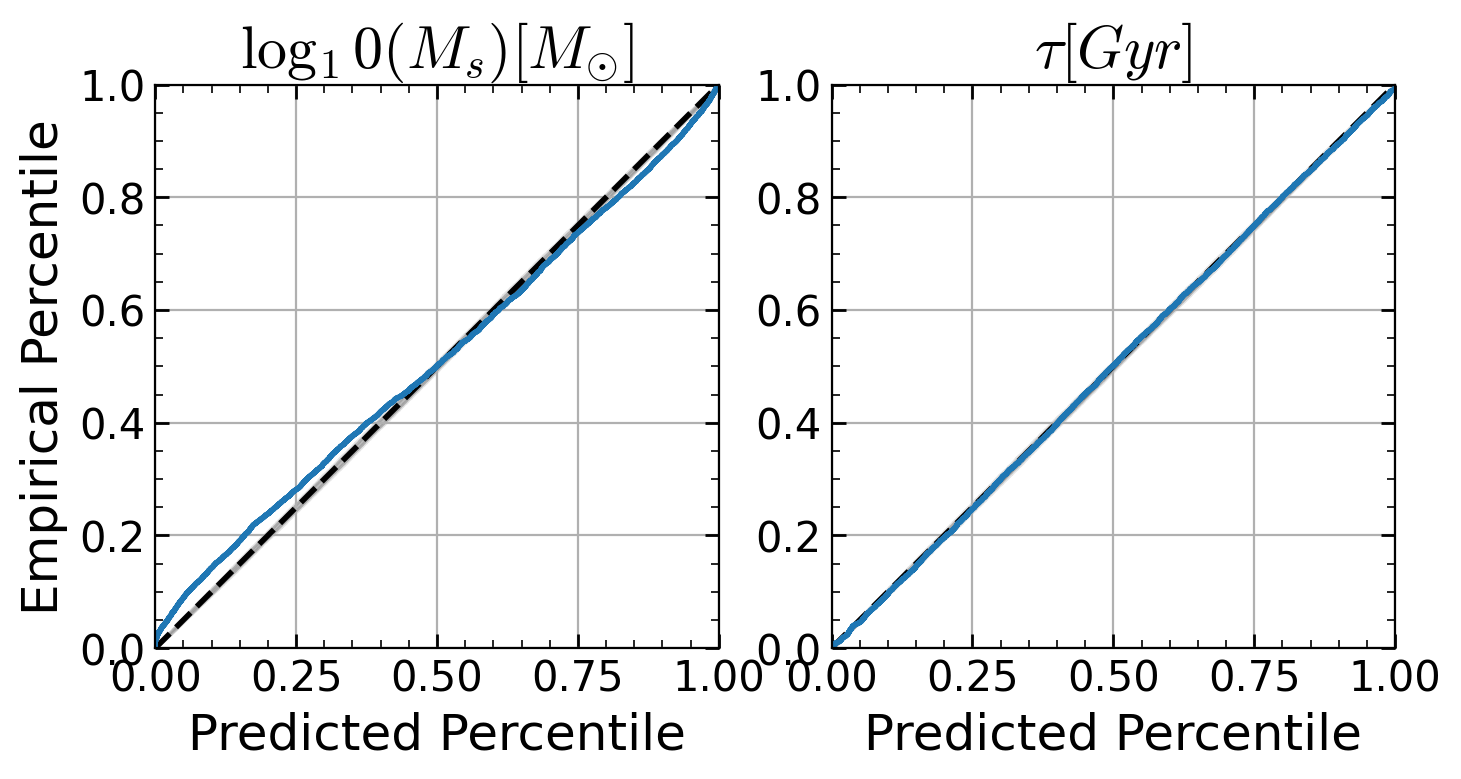

In [36]:
plot_hist = [ "coverage"]
# plot_hist = [ "tarp"]
metric = PosteriorCoverage(
    num_samples=2_000, sample_method='direct',
    labels=[rf'$\log_{{10}}(M_{{s}}) [M_{{\odot}}]$', rf'$\tau [Gyr]$'], plot_list = plot_hist
)
fig = metric(
    posterior=posterior_ensemble,
    x=test_x, theta=test_theta)

fig[0].savefig('./coverage.pdf')


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


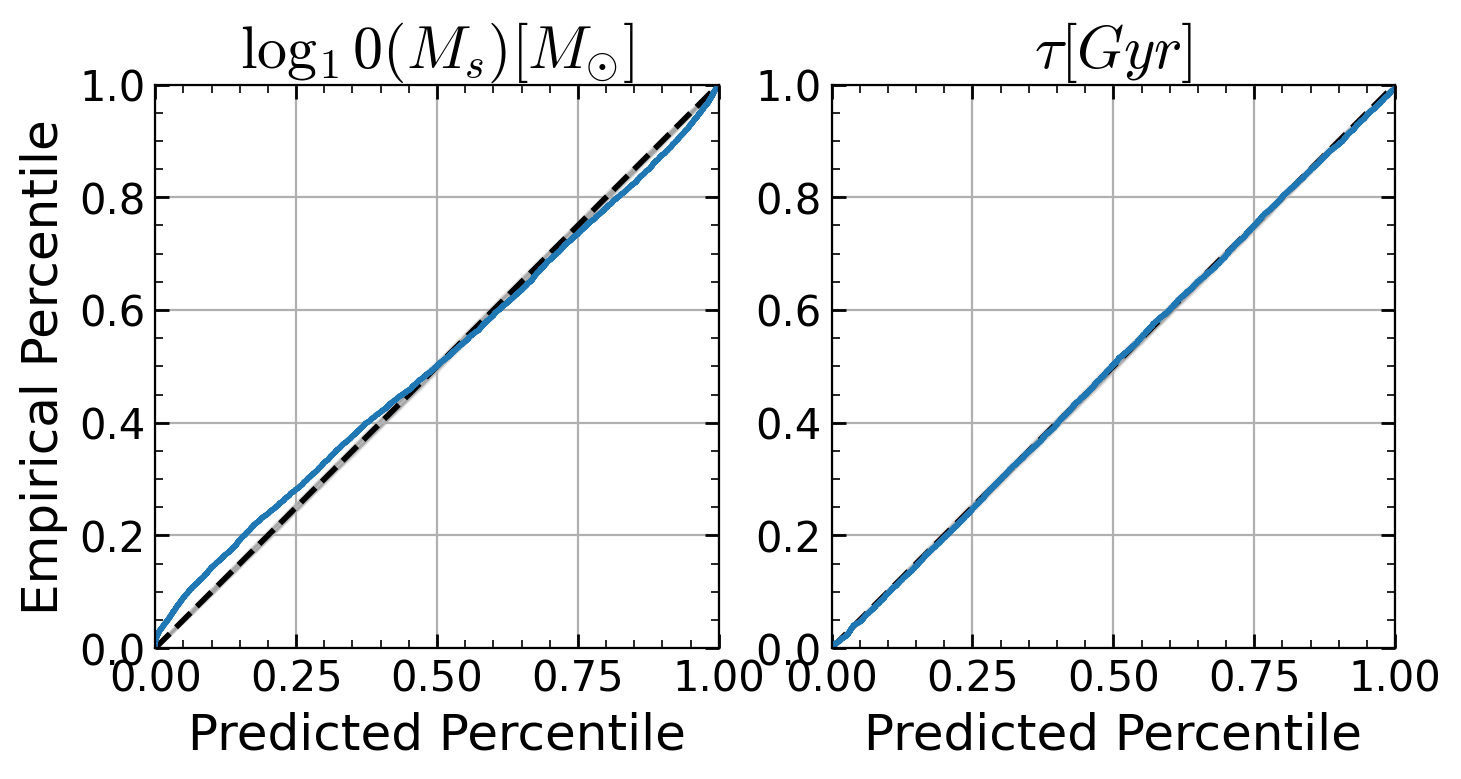

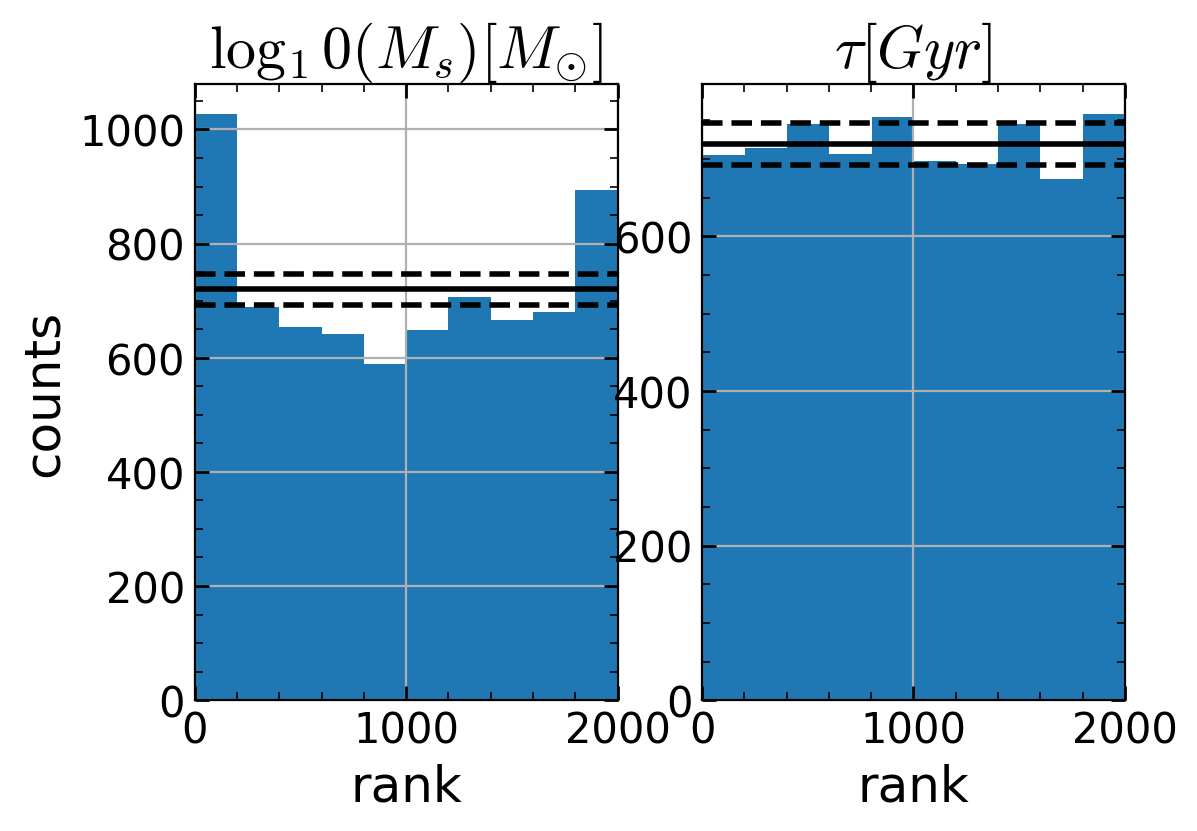

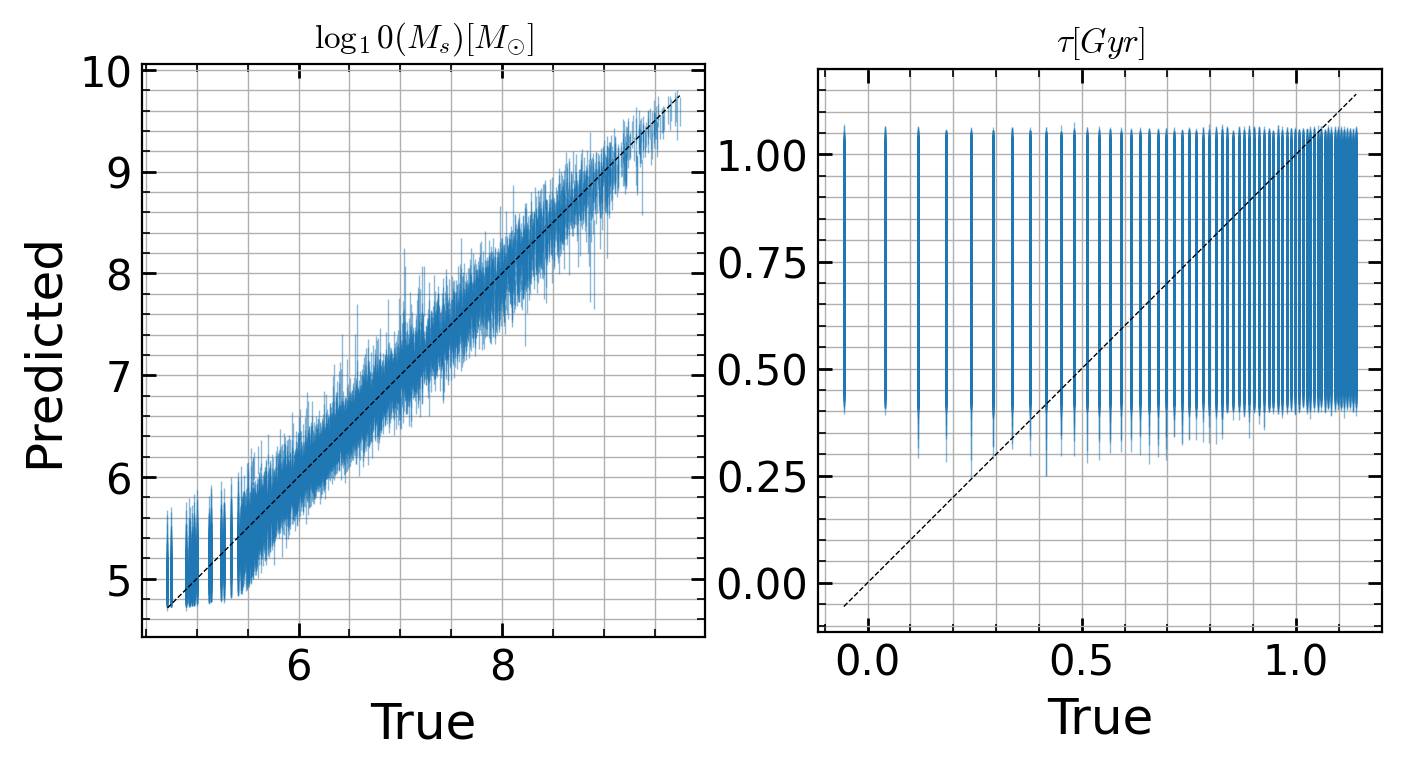

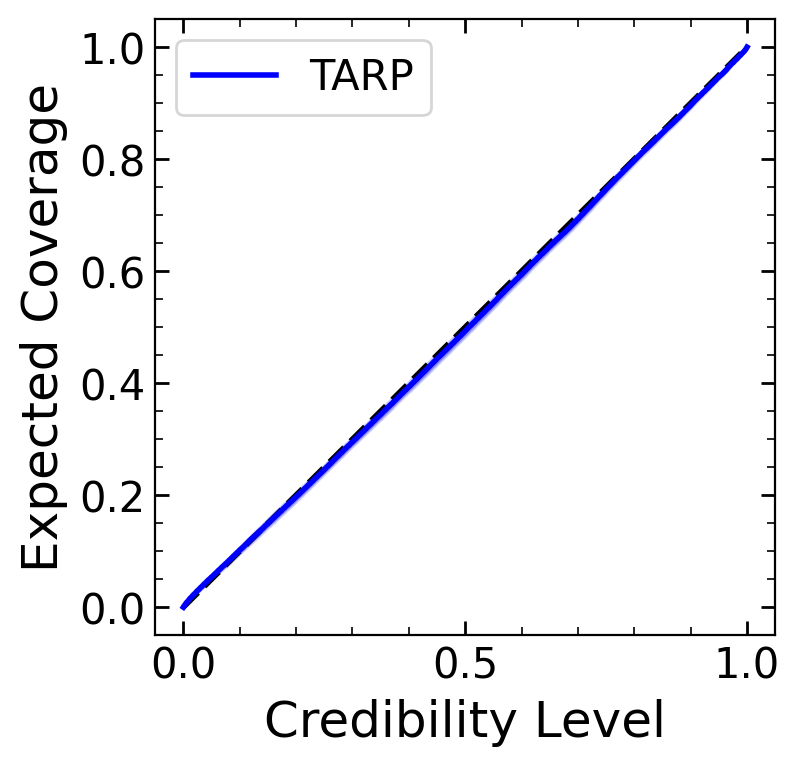

In [9]:
plot_hist = ["coverage", "histogram", "predictions", "tarp"]
# plot_hist = [ "tarp"]
metric = PosteriorCoverage(
    num_samples=2_000, sample_method='direct',
    labels=[rf'$\log_{{10}}(M_{{s}}) [M_{{\odot}}]$', rf'$\tau [Gyr]$'], plot_list = plot_hist
)
fig = metric(
    posterior=posterior_ensemble,
    x=test_x, theta=test_theta)

fig[0].savefig('./coverage.pdf')
fig[1].savefig('./predictions.pdf')
fig[2].savefig('./true_vs_predicted.pdf')
fig[3].savefig('./tarp.pdf')
    


In [7]:
# import pickle
# from os.path import join
# samples = {}
# with open(join('./', 'posterior.pkl'), 'rb') as f:
#     samples['NPE'] = pickle.load(f)
    

# metric = PosteriorCoverage(
#     num_samples=5_000, sample_method='direct',
#     labels=[rf'$M_{{s}}\ [M_\odot]$', rf'$\tau [Gyr]$'], plot_list = ["coverage", "histogram", "predictions", "tarp"]
# )
# fig = metric(
#     posterior=samples['NPE'],
#     x=test_x, theta=test_theta)

# fig[0].savefig('./coverage.png')
# fig[1].savefig('./predictions.png')
# fig[3].savefig('./tarp.png')

INFO:root:Sampling models with tensor([247., 258., 239., 257.], device='cuda:0') samples each.
Drawing 247 posterior samples: 492it [00:00, 4226.86it/s]             
Drawing 258 posterior samples: 515it [00:00, 4400.73it/s]             
Drawing 239 posterior samples: 473it [00:00, 4209.36it/s]             
Drawing 257 posterior samples: 511it [00:00, 4570.13it/s]             
INFO:root:Sampling models with tensor([247., 258., 239., 257.], device='cuda:0') samples each.
Drawing 257 posterior samples: 100%|██████████| 257/257 [00:00<00:00, 4503.15it/s]
INFO:root:Sampling models with tensor([247., 258., 239., 257.], device='cuda:0') samples each.
Drawing 247 posterior samples: 100%|██████████| 247/247 [00:00<00:00, 4416.52it/s]
Drawing 258 posterior samples: 514it [00:00, 4496.93it/s]             
Drawing 257 posterior samples: 100%|██████████| 257/257 [00:00<00:00, 4416.88it/s]
INFO:root:Sampling models with tensor([247., 258., 239., 257.], device='cuda:0') samples each.
Drawing 247 post

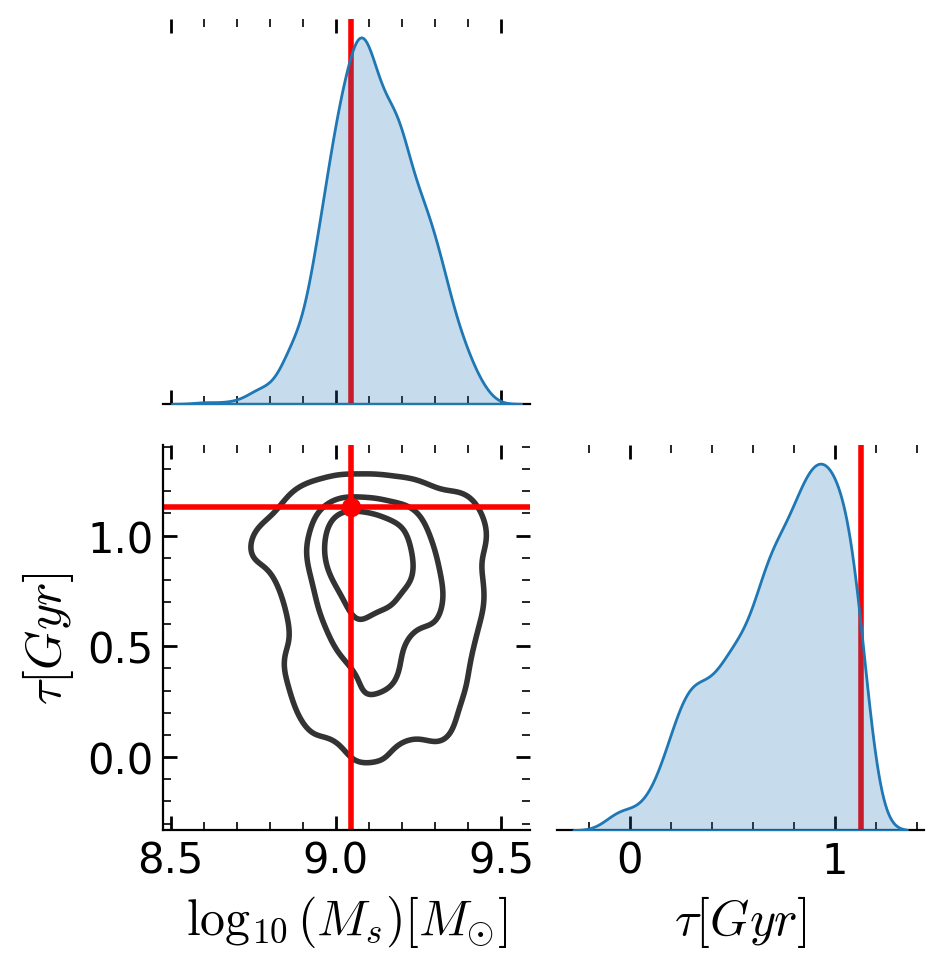

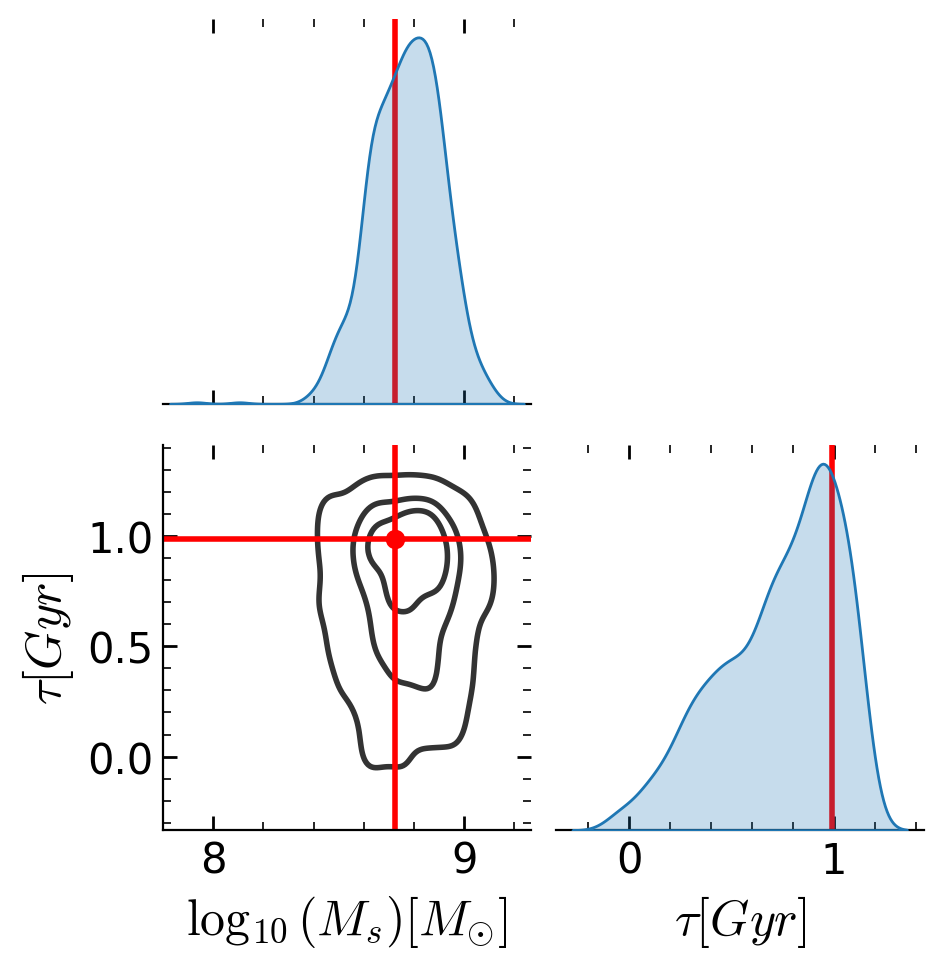

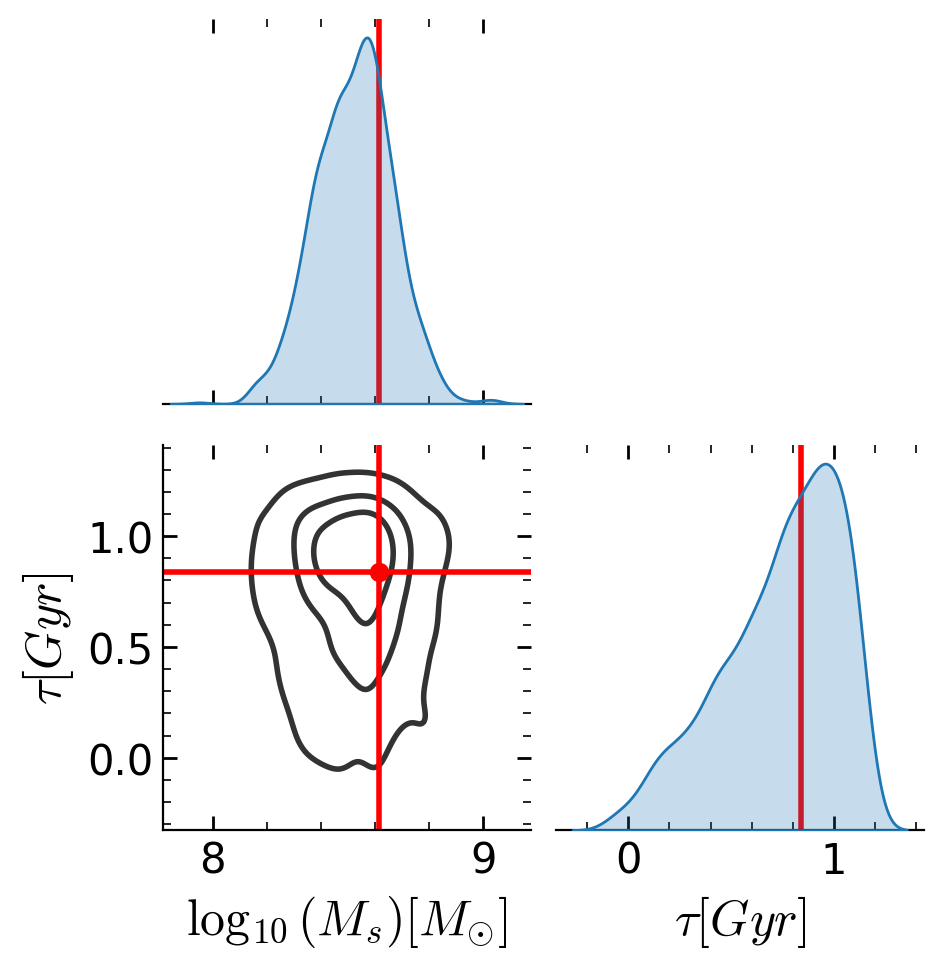

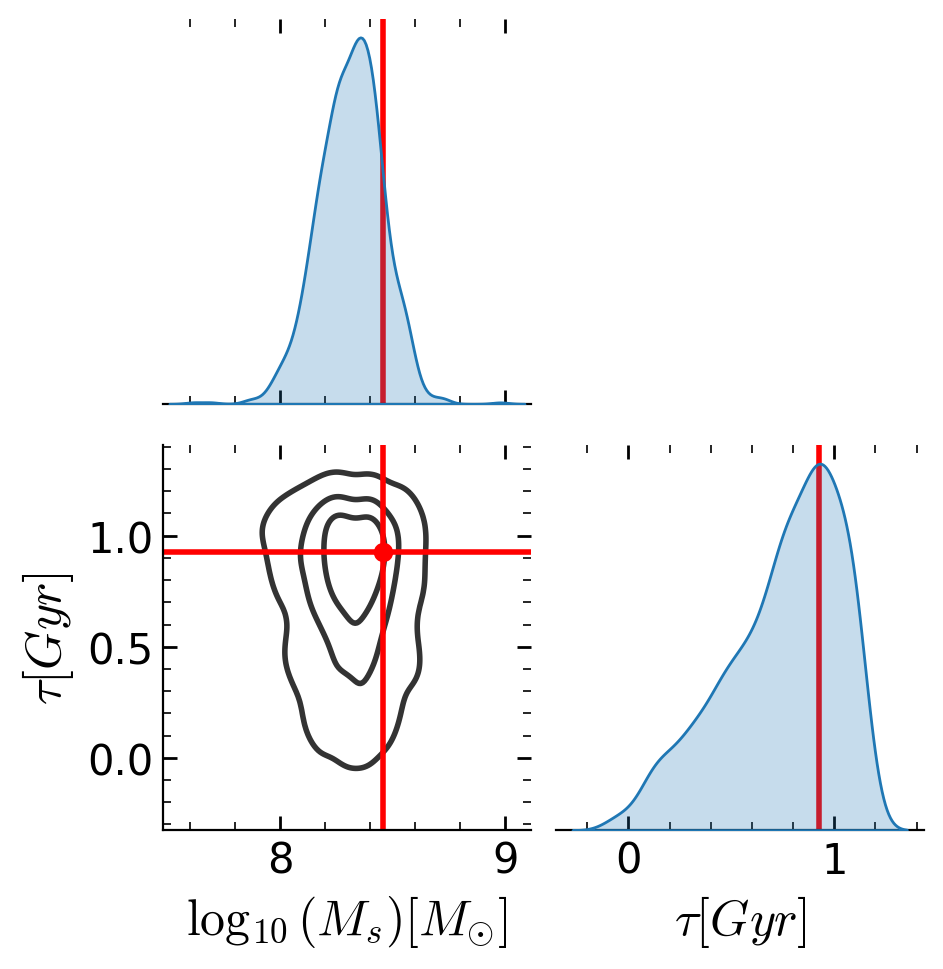

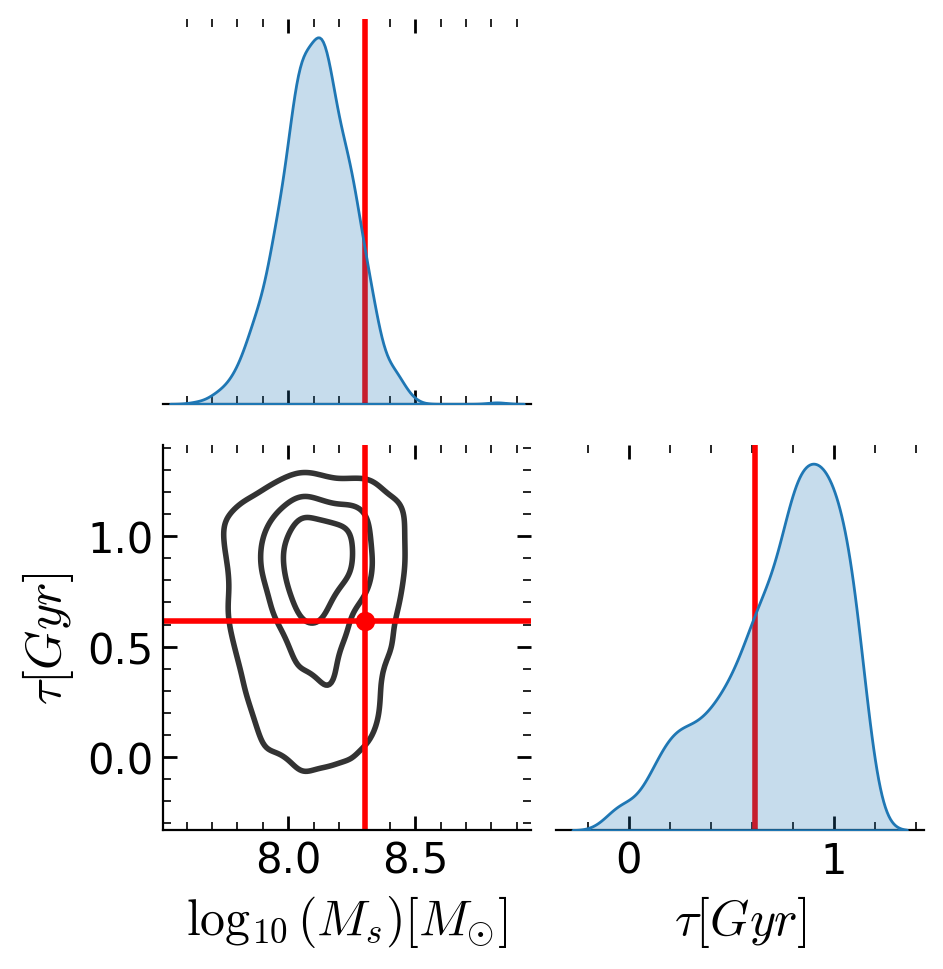

In [44]:
for i in range(10)[::2]:
    # use ltu-ili's built-in validation metrics to plot the posterior for this point
    metric = PlotSinglePosterior(
        num_samples=1000, sample_method='direct', 
        labels=[rf'$\log_{{10}}(M_{{s}}) [M_{{\odot}}]$', rf'$\tau [Gyr]$'],
    )
    fig = metric(
        posterior=posterior_ensemble,
        x_obs=test_x[i], theta_fid=test_theta[i]
    )